In [17]:
# Importação das bibliotecas

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import tensorflow as tf

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import math

# Random seed 
np.random.seed(0)

In [18]:
# Carrega o dataset

df_stock = pd.read_csv('Microsoft_Stock.csv', usecols=[4], engine = 'python')

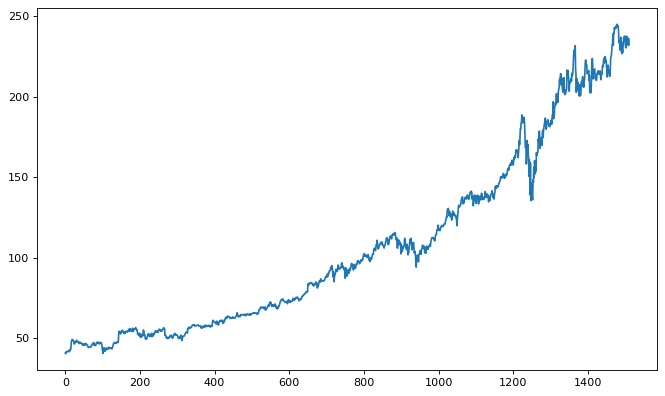

In [19]:
# plot 

figure(figsize=(10, 6), dpi=80)
plt.plot(df_stock)
plt.show()

In [20]:
# Checando se há valores missing no dataframe

df_stock.isnull().sum()

Close    0
dtype: int64

In [21]:
# Normalizando os dados
# As LSTMs são sensíveis à escala dos dados de entrada, especificamente quando funções de ativação sigmoide (padrão)
# ou tanh são usadas. Pode ser uma boa prática redimensionar os dados para o range de 0 a 1, 
# também chamado de normalização. Podemos normalizar facilmente o conjunto de dados usando a classe MinMaxScaler do scikit-learn

scaler = MinMaxScaler(feature_range = (0, 1))

df_stock = scaler.fit_transform(df_stock)

In [22]:
# Dividindo os dados em treino e teste

train_size = int(len(df_stock) * 0.75)
test_size = len(df_stock) - train_size
train, test = df_stock[0:train_size,:], df_stock[train_size:len(df_stock),:]

In [23]:
# Converte array em matriz

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
# Reshape em X=t e Y=t+1

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [25]:
# Reshape do input para: [samples, time steps, features]
# A rede LSTM espera que os dados de entrada (X) sejam fornecidos com uma estrutura de matriz específica 
# na forma de: [amostras, etapas de tempo, características]. Nossos dados preparados estão na forma: [amostras,
# features] e estamos enquadrando o problema como um único passo para cada amostra. Podemos transformar
# os dados de treino e de teste na estrutura esperada usando numpy.reshape() 

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [26]:
# Cria o modelo LSTM
# Agora estamos prontos para projetar nossa rede LSTM para esse problema. A rede tem uma
# camada visível com 1 entrada, uma camada oculta com 4 blocos LSTM ou neurônios e uma camada de saída
# que faz uma previsão de valor único. A função de ativação sigmoid padrão é usada para
# os blocos de memória LSTM. A rede é treinada em 50 épocas e um tamanho de lote (batch_size) de 1 é usado.

model = Sequential()
model.add(LSTM(4, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 50, batch_size = 1, verbose = 2)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1129/1129 - 10s - loss: 0.0067 - 10s/epoch - 9ms/step
Epoch 2/50
1129/1129 - 3s - loss: 6.4873e-05 - 3s/epoch - 3ms/step
Epoch 3/50
1129/1129 - 3s - loss: 6.2478e-05 - 3s/epoch - 3ms/step
Epoch 4/50
1129/1129 - 3s - loss: 6.2549e-05 - 3s/epoch - 3ms/step
Epoch 5/50
1129/1129 - 3s - loss: 6.5028e-05 - 3s/epoch - 3ms/step
Epoch 6/50
1129/1129 - 3s - loss: 6.2560e-05 - 3s/epoch - 3ms/step
Epoch 7/50
1129/1129 - 3s - loss: 6.3318e-05 - 3s/epoch - 3ms/step
Epoch 8/50
1129/1129 - 3s - loss: 6.4729e-05 - 3s/epoch - 3ms/step
Epoch 9/50
1129/1129 - 3s - loss: 6.0264e-05 - 3s/epoch - 3ms/step
Epoch 10/50
1129/1129 - 3s - loss: 6.1957e-05 - 3s/epoch - 3ms/step
Epoch 11/50
1129/112

In [27]:
# Previsões

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [28]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [29]:
# Calcula o RMSE

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.2f RMSE' % (testScore))

Score em Treino: 1.41 RMSE
Score em Teste: 12.65 RMSE


In [30]:
# Ajusta as previsões em treino para o plot

trainPredictPlot = np.empty_like(df_stock)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [31]:
# Ajusta as previsões em teste para o plot

testPredictPlot = np.empty_like(df_stock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_stock)-1, :] = testPredict

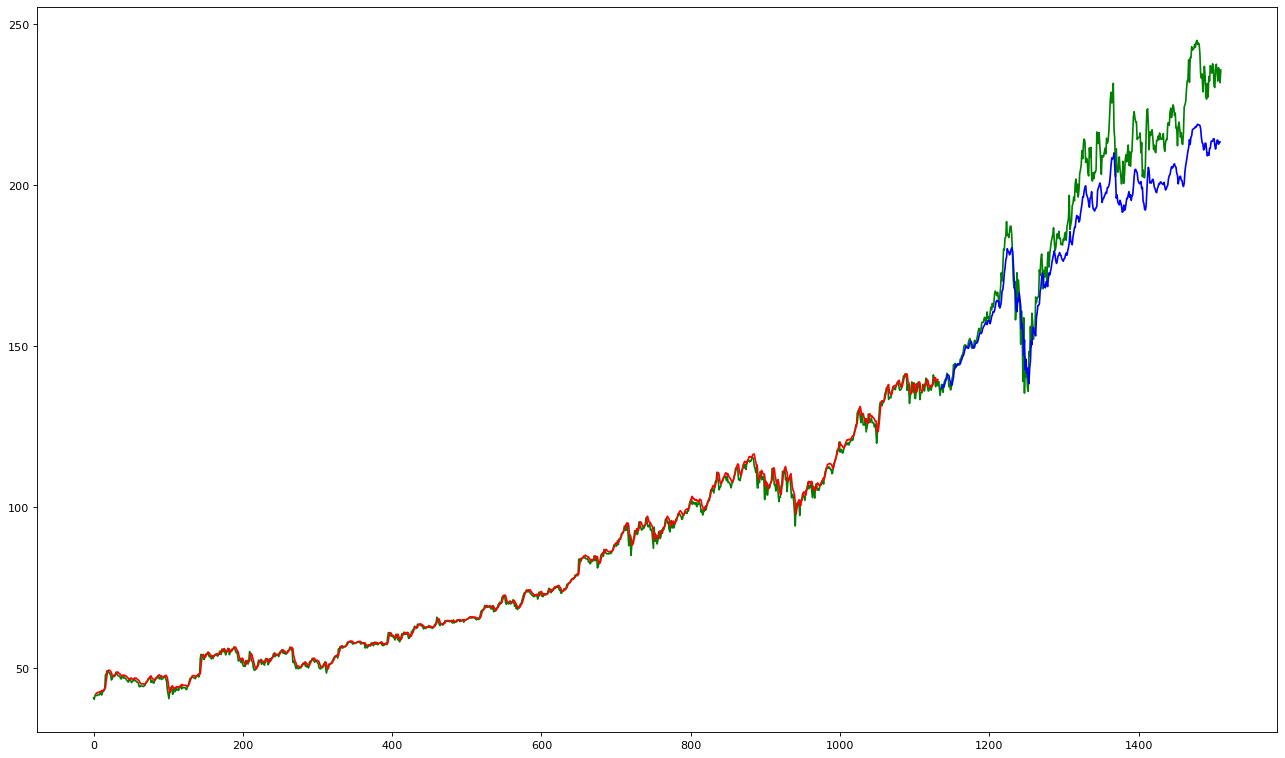

In [32]:
# Plot do baseline e previsões

figure(figsize=(20, 12), dpi=80)
plt.plot(scaler.inverse_transform(df_stock), 'g')
plt.plot(trainPredictPlot, 'r')
plt.plot(testPredictPlot, 'b')
plt.show()